In [1]:
'''math tool'''
import csv
import numpy as np
import copy

'''plot tool'''
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.ticker as ticker

'''image tool'''
import cv2
#import pyrealsense2 as rs
import statistics as sta

## load 3 layers map and create respective color/gray image and accu_map

In [2]:
raw_pgm_35 = cv2.imread("/home/ncslaber/110-1/211002_allLibrary/2021-10-02-17-29-15/1116_test2_after_preprocess/30-50/1116.pgm")
raw_pgm_57 = cv2.imread("/home/ncslaber/110-1/211002_allLibrary/2021-10-02-17-29-15/1116_test2_after_preprocess/50-70/1116.pgm")
raw_pgm_79 = cv2.imread("/home/ncslaber/110-1/211002_allLibrary/2021-10-02-17-29-15/1116_test2_after_preprocess/70-90/1116.pgm")
# if raw_pgm is None:
#     print("Image is empty!!")
raw_pgm_color_35 = np.zeros(raw_pgm_35.shape,dtype=np.uint8) + 255
raw_pgm_color_57 = np.zeros(raw_pgm_57.shape,dtype=np.uint8) + 255
raw_pgm_color_79 = np.zeros(raw_pgm_79.shape,dtype=np.uint8) + 255
raw_pgm_35 = cv2.cvtColor(raw_pgm_35, cv2.COLOR_RGB2GRAY)
raw_pgm_57 = cv2.cvtColor(raw_pgm_57, cv2.COLOR_RGB2GRAY)
raw_pgm_79 = cv2.cvtColor(raw_pgm_79, cv2.COLOR_RGB2GRAY)
(width, height) = raw_pgm_79.shape # the order is right
print("pgm height is: ",height)

pgm height is:  2048


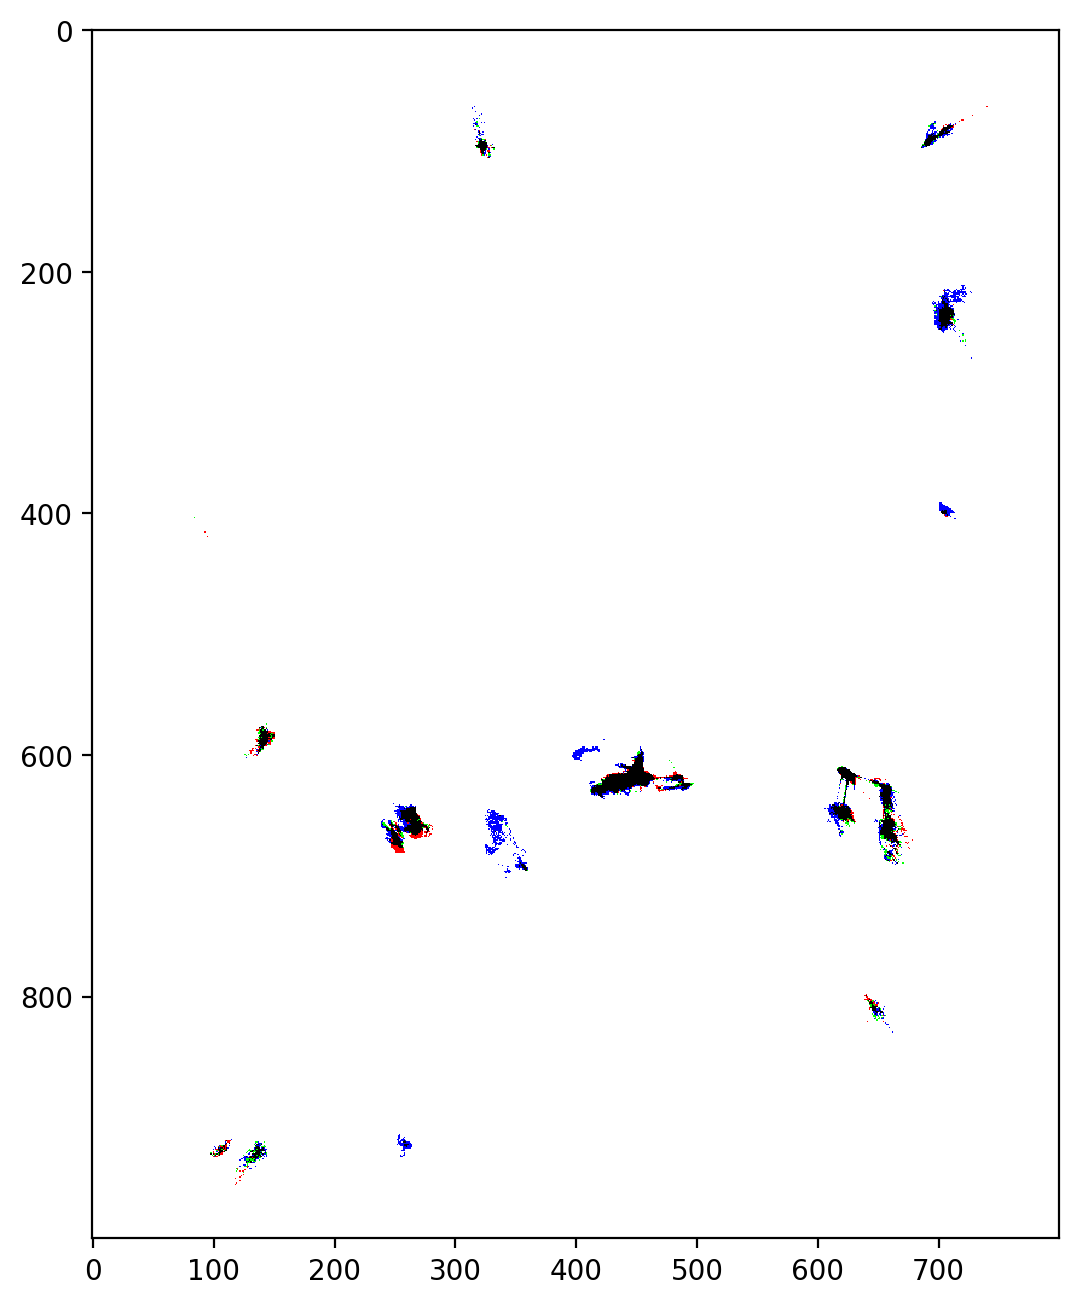

In [3]:
raw_pgm_color_35[raw_pgm_35==0]=(0,0,255)
raw_pgm_color_57[raw_pgm_57==0]=(0,255,0)
raw_pgm_color_79[raw_pgm_79==0]=(255,0,0)
accu_map = cv2.bitwise_and(raw_pgm_color_35, raw_pgm_color_57)
accu_map = cv2.bitwise_and(accu_map, raw_pgm_color_79)
fig3, ax3 = plt.subplots(figsize=(8, 8),dpi=200)
plt.imshow(cv2.cvtColor(accu_map[700:1700,700:1500], cv2.COLOR_BGR2RGB))

In [23]:
np.save('/home/ncslaber/110-1/211002_allLibrary/2021-10-02-17-29-15/1116_test2_after_preprocess/color_map',accu_map)

## find connected component

In [4]:
def morph_map(raw_pgm_binary):
    kernel = np.ones((3,3), np.uint8)
    raw_pgm_binary = cv2.dilate(raw_pgm_binary, kernel, iterations = 1)
    raw_pgm_binary = cv2.erode(raw_pgm_binary,kernel,iterations = 1)
#     fig = plt.figure(figsize=(10,10))
#     subplot = fig.add_subplot(121)
#     subplot.imshow(cv2.cvtColor(raw_pgm, cv2.COLOR_BGR2RGB))
#     subplot = fig.add_subplot(122)
#     subplot.imshow(cv2.cvtColor(raw_pgm_binary, cv2.COLOR_BGR2RGB))
#     plt.imshow(cv2.cvtColor(raw_pgm_binary[700:1700,700:1500], cv2.COLOR_BGR2RGB))
    return raw_pgm_binary

In [17]:
def filter_labels(num_objects, labels):
    filter_labels_list = []
    trunk_label_dict = {}
    count = 0
    for i in range(num_objects):
        if len(labels[labels==i])>21 and len(labels[labels==i])<1000:
#             if (accu_map[labels==i,:][:,0] == 255).all():
#                 print("leaves")
#             else:
                filter_labels_list.append(i)
                count+=1
                trunk_label_dict[count] = {'num-of-label': len(labels[labels==i]), 'label-code':i}
    return filter_labels_list, trunk_label_dict

In [18]:
filter_labels_list, trunk_label_dict = filter_labels(num_objects, labels)
filter_labels_list, trunk_label_dict

([2, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22],
 {1: {'num-of-label': 92, 'label-code': 2},
  2: {'num-of-label': 86, 'label-code': 4},
  3: {'num-of-label': 341, 'label-code': 6},
  4: {'num-of-label': 76, 'label-code': 8},
  5: {'num-of-label': 168, 'label-code': 9},
  6: {'num-of-label': 858, 'label-code': 10},
  7: {'num-of-label': 135, 'label-code': 11},
  8: {'num-of-label': 179, 'label-code': 12},
  9: {'num-of-label': 215, 'label-code': 13},
  10: {'num-of-label': 238, 'label-code': 14},
  11: {'num-of-label': 673, 'label-code': 15},
  12: {'num-of-label': 227, 'label-code': 16},
  13: {'num-of-label': 47, 'label-code': 18},
  14: {'num-of-label': 70, 'label-code': 19},
  15: {'num-of-label': 53, 'label-code': 20},
  16: {'num-of-label': 137, 'label-code': 21},
  17: {'num-of-label': 47, 'label-code': 22}})

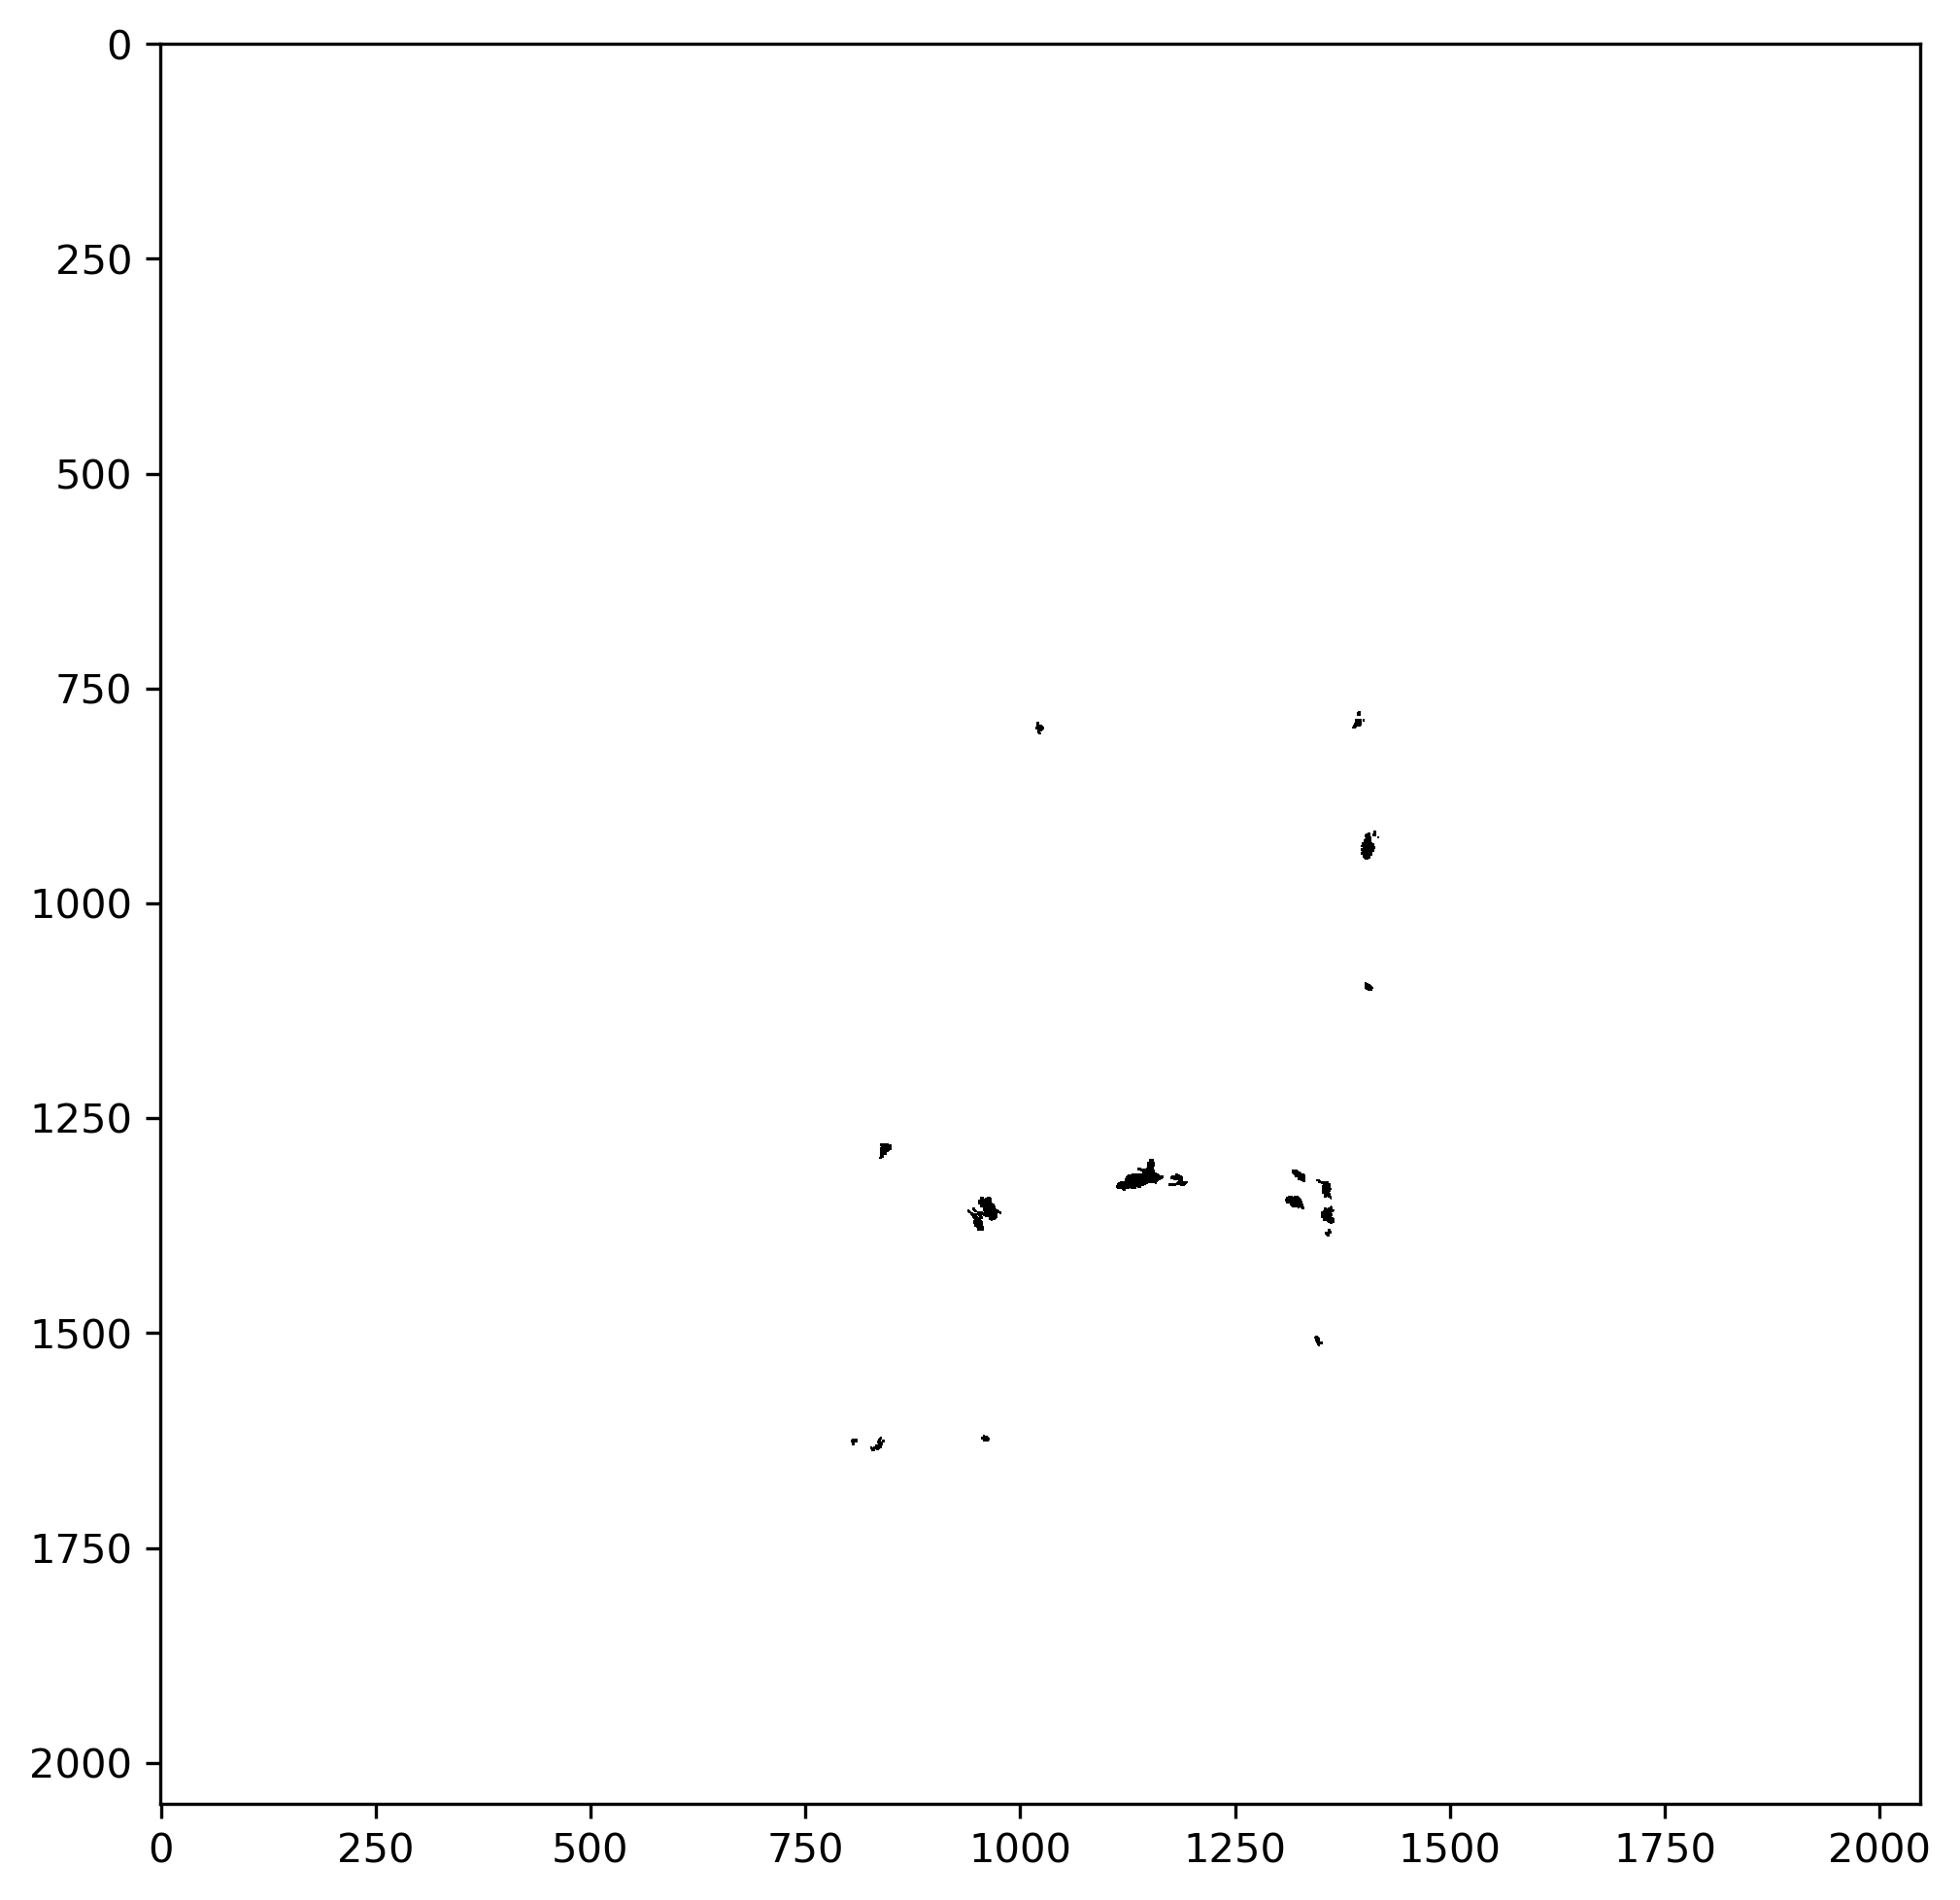

>>>># of raw objects: 23


(23,
 (2048, 2048),
 {1: {'num-of-label': 92, 'label-code': 2},
  2: {'num-of-label': 86, 'label-code': 4},
  3: {'num-of-label': 21, 'label-code': 5},
  4: {'num-of-label': 341, 'label-code': 6},
  5: {'num-of-label': 76, 'label-code': 8},
  6: {'num-of-label': 168, 'label-code': 9},
  7: {'num-of-label': 135, 'label-code': 11},
  8: {'num-of-label': 179, 'label-code': 12},
  9: {'num-of-label': 215, 'label-code': 13},
  10: {'num-of-label': 238, 'label-code': 14},
  11: {'num-of-label': 673, 'label-code': 15},
  12: {'num-of-label': 227, 'label-code': 16},
  13: {'num-of-label': 21, 'label-code': 17},
  14: {'num-of-label': 47, 'label-code': 18},
  15: {'num-of-label': 70, 'label-code': 19},
  16: {'num-of-label': 53, 'label-code': 20},
  17: {'num-of-label': 137, 'label-code': 21},
  18: {'num-of-label': 47, 'label-code': 22}})

In [8]:
raw_pgm_binary_all = np.zeros(raw_pgm_35.shape,dtype=np.uint8) + 255
mask = np.logical_or( np.logical_or(raw_pgm_35==0, raw_pgm_57==0), raw_pgm_79==0 )
raw_pgm_binary_all[mask]=0
morph_pgm_binary_all = morph_map(raw_pgm_binary_all)

file_path = '/home/ncslaber/110-1/211002_allLibrary/2021-10-02-17-29-15/1116_test2_after_preprocess/'
tmp_raw_pgm = cv2.imread(file_path+"raw_modified_700-1700_700-1500.png")
tmp_raw_pgm = cv2.cvtColor(tmp_raw_pgm, cv2.COLOR_RGB2GRAY)
morph_pgm_binary_all[700:1700,700:1500] = tmp_raw_pgm
fig1,ax1 = plt.subplots(figsize=(8,8),dpi=300)
plt.imshow(cv2.cvtColor(morph_pgm_binary_all, cv2.COLOR_BGR2RGB))
plt.show()

tmp = np.zeros(raw_pgm_35.shape,dtype=np.uint8) 
tmp[morph_pgm_binary_all==0]=255
num_objects, labels = cv2.connectedComponents(tmp)
filter_labels_list, trunk_label_dict = filter_labels(num_objects, labels)
print('>>>># of raw objects:',num_objects)
num_objects,labels.shape, trunk_label_dict

In [25]:
cv2.imwrite('/home/ncslaber/110-1/211002_allLibrary/2021-10-02-17-29-15/1116_test2_after_preprocess/raw_modified.png', morph_pgm_binary_all)
# np.save('/home/ncslaber/110-1/211002_allLibrary/2021-10-02-17-29-15/1116_test2_after_preprocess/raw_modified',morph_pgm_binary_all)

True

In [11]:
def get_matched_circle(raw_pgm_binary, filter_labels_list, tmp_color):
    centroid_rawList = []
    circle_bd = np.zeros(raw_pgm_binary.shape, dtype=np.uint8)
    for i in filter_labels_list:
        A = []
        for x in range(raw_pgm_binary.shape[0]):
            for y in range(raw_pgm_binary.shape[1]):
                if labels[x][y] == i:
                    A.append(np.array([-x/(x*x+y*y), -y/(x*x+y*y), -1/(x*x+y*y)]))
        A = np.asarray(A)
        print('new one circle # of points: ', A.shape)
        
        k = np.linalg.inv(A.T @ A)
        k = k @ A.T
        k = k @ np.ones((k.shape[1],1))
        
        centre_x = k[0][0]/(-2)
        centre_y = k[1][0]/(-2)
        radius_r = np.sqrt(centre_x*centre_x+centre_y*centre_y-k[2][0])
        print('x,y,r: ', int(centre_x+0.5), int(centre_y+0.5), int(radius_r+0.5))
        
        centroid_rawList.append((int(centre_x+0.5),int(centre_y+0.5),int(radius_r+0.5)))

        cv2.circle(circle_bd,(int(centre_y), int(centre_x)), int(radius_r+0.5), 150, 2)
        cv2.circle(tmp_color,(int(centre_y), int(centre_x)), int(radius_r+0.5), (150,150,150), 2)
        # cv2.putText(circle_bd, #numpy array on which text is written
        #             str(int(centre_x))+','+str(int(centre_y))+','+str(int(radius_r)), #text
        #             (int(centre_y)-20,int(centre_x)-20), #position at which writing has to start
        #             cv2.FONT_HERSHEY_SIMPLEX, #font family
        #             0.6, #font size
        #             255, #font color
        #             1, cv2.LINE_AA) #font stroke
#         cv2.imshow('circle_bd',circle_bd)
#         cv2.waitKey(100)
    circle_bd[raw_pgm_binary==255]=255
    fig1,ax1 = plt.subplots(figsize=(8,8),dpi=100)
    plt.imshow(cv2.cvtColor(tmp_color, cv2.COLOR_BGR2RGB))
    plt.show()
    plt.imshow(cv2.cvtColor(circle_bd, cv2.COLOR_BGR2RGB))
    plt.show()
#     cv2.imwrite(file_path+'raw_circle_bd.png', circle_bd)

    return centroid_rawList

new one circle # of points:  (92, 3)
x,y,r:  791 1392 4
new one circle # of points:  (86, 3)
x,y,r:  796 1022 4
new one circle # of points:  (341, 3)
x,y,r:  934 1404 8
new one circle # of points:  (76, 3)
x,y,r:  1096 1406 4
new one circle # of points:  (168, 3)
x,y,r:  1287 842 6
new one circle # of points:  (858, 3)
x,y,r:  1318 1138 16
new one circle # of points:  (135, 3)
x,y,r:  1317 1324 6
new one circle # of points:  (179, 3)
x,y,r:  1323 1183 7
new one circle # of points:  (215, 3)
x,y,r:  1332 1353 8
new one circle # of points:  (238, 3)
x,y,r:  1348 1320 7
new one circle # of points:  (673, 3)
x,y,r:  1360 958 13
new one circle # of points:  (227, 3)
x,y,r:  1362 1359 6
new one circle # of points:  (47, 3)
x,y,r:  1383 1359 3
new one circle # of points:  (70, 3)
x,y,r:  1509 1347 4
new one circle # of points:  (53, 3)
x,y,r:  1622 960 3
new one circle # of points:  (137, 3)
x,y,r:  1629 833 6
new one circle # of points:  (47, 3)
x,y,r:  1626 807 3


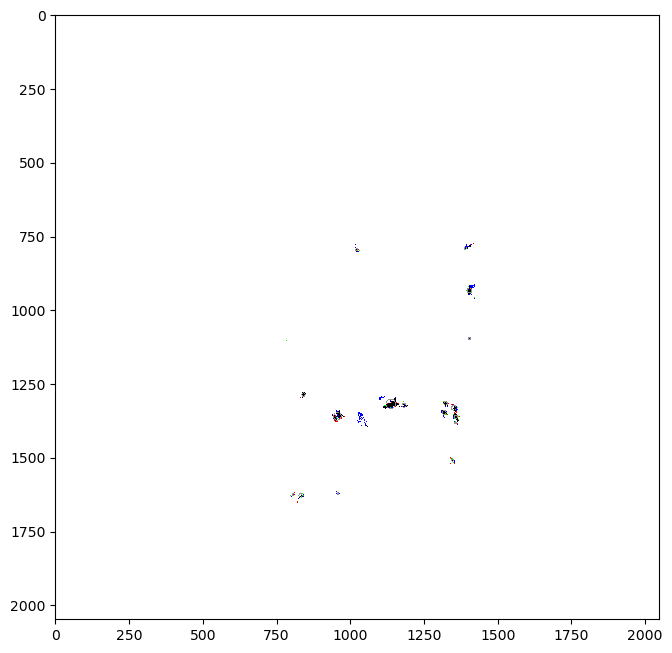

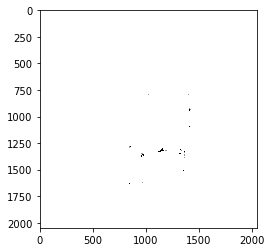

In [19]:
tmp_color = copy.deepcopy(accu_map)
centroid_rawList = get_matched_circle(morph_pgm_binary_all, filter_labels_list, tmp_color)

In [27]:
i=0
for item in trunk_label_dict.keys():
    
    trunk_label_dict[item]['signature_pixl']=centroid_rawList[i]
    i+=1
trunk_label_dict

{1: {'num-of-label': 92,
  'label-code': 2,
  'signature': (791, 1392, 4),
  'signature_pixl': (791, 1392, 4)},
 2: {'num-of-label': 86,
  'label-code': 4,
  'signature': (796, 1022, 4),
  'signature_pixl': (796, 1022, 4)},
 3: {'num-of-label': 341,
  'label-code': 6,
  'signature': (934, 1404, 8),
  'signature_pixl': (934, 1404, 8)},
 4: {'num-of-label': 76,
  'label-code': 8,
  'signature': (1096, 1406, 4),
  'signature_pixl': (1096, 1406, 4)},
 5: {'num-of-label': 168,
  'label-code': 9,
  'signature': (1287, 842, 6),
  'signature_pixl': (1287, 842, 6)},
 6: {'num-of-label': 858,
  'label-code': 10,
  'signature': (1318, 1138, 16),
  'signature_pixl': (1318, 1138, 16)},
 7: {'num-of-label': 135,
  'label-code': 11,
  'signature': (1317, 1324, 6),
  'signature_pixl': (1317, 1324, 6)},
 8: {'num-of-label': 179,
  'label-code': 12,
  'signature': (1323, 1183, 7),
  'signature_pixl': (1323, 1183, 7)},
 9: {'num-of-label': 215,
  'label-code': 13,
  'signature': (1332, 1353, 8),
  'signa

In [36]:
len(centroid_rawList)

0

## to UTM

In [28]:
def transform_from_pixel2m(cX, cY,length):  # Here effects initial position
    # cX_m, cY_m = transformation(cX, cY, -0.5*np.pi, -int(length*(1-map_start_y)), int(length*(1-map_start_x)))
    
    cX_m = cX - int(length*0.5) # initial position in the map #0.3
    cY_m = cY - int(length*0.5) # 0.5
    
    cX_m *= resolution_pixel
    cY_m *= resolution_pixel
    return cX_m, cY_m

def get_utm_negBDs_from_center(index, cX_m, cY_m, cR_m, utm_x_ref, utm_y_ref):
    number_of_point = 12
    piece_rad = np.pi/(number_of_point/2)
    neg_bd = []
    for i in range(number_of_point):
        neg_bd.append((cX_m+(cR_m+0.5)*np.cos(piece_rad*i)+utm_x_ref, cY_m+(cR_m+0.5)*np.sin(piece_rad*i)+utm_y_ref))
    neg_bd = np.asarray(neg_bd)
    plt.scatter(neg_bd[:,0], neg_bd[:,1], c='b', s=10)
    plt.scatter(cX_m+utm_x_ref, cY_m+utm_y_ref, c='g')
#     np.save(shp_path+'neg_'+str(index+1)+'_bd_utm', neg_bd)
#     np.save(shp_path+'center_'+str(index+1)+'_bd_utm', (cX_m+utm_x_ref, cY_m+utm_y_ref, cR_m))

    return neg_bd

In [ ]:
# lng, lat, zone, R = get_init_utm()
# proj = Proj(proj='utm', zone=zone, ellps='WGS84', preserve_units=False)
utm_x_ref, utm_y_ref = 352874.9314219437, 2767711.122274709

fig2,ax2 = plt.subplots(figsize=(7,5))
for j in range(centre_x_list.shape[0]):
    cX = centre_x_list[j]
    cY = centre_y_list[j]
    cX_m, cY_m = transform_from_pixel2m(cX, cY, raw_pgm.shape[0])
    cR_m = radius_list[j]/20

    neg_bd = get_utm_negBDs_from_center(j, cX_m, cY_m, cR_m, utm_x_ref, utm_y_ref)


In [34]:
from scipy.spatial import distance as dist
def get_merging_circle(raw_pgm_binary, filter_labels_list):
    circle_bd = np.zeros(raw_pgm_binary.shape, dtype=np.uint8)
    centroid_filteredList = []

    while len(centroid_rawList) > 0:
        count = 1
        centroid = centroid_rawList.pop(0)
        
        indexX = centroid[0]
        indexY = centroid[1]
        indexR = centroid[2]
        i = 0 
        # leng = len(centroidList)-1
        while True:
            if i < len(centroid_rawList):
                eDist = dist.euclidean(np.asarray(centroid), np.asarray(centroid_rawList[i]))
                if eDist < 25: # 1m
                    print("merging centroid...")
                    centroid_tmp = centroid_rawList.pop(i)
                    indexX += centroid_tmp[0]
                    indexY += centroid_tmp[1]
                    indexR += centroid_tmp[2]
                    print('     x,y,r: ', centroid_tmp)
                    count += 1
                    centroid = (indexX/count, indexY/count, indexR/count)
                    i -= 1
                i += 1
            else:
                break
        centroid_filteredList.append(centroid)
        cv2.circle(circle_bd, (int(centroid[1]),int(centroid[0])), int(centroid[2]), 150, 3) # radius is 8 pixel
        # cv2.putText(circle_bd, #numpy array on which text is written
        #             str(int(centroid[0]))+','+str(int(centroid[1]))+','+str(int(centroid[2])), #text
        #             (int(centroid[1])-20,int(centroid[0])-20), #position at which writing has to start
        #             cv2.FONT_HERSHEY_SIMPLEX, #font family
        #             0.6, #font size
        #             255, #font color
        #             1, cv2.LINE_AA) #font stroke
    circle_bd[raw_pgm_binary==255]=255
    fig2,ax2 = plt.subplots(figsize=(15,15))
    plt.imshow(cv2.cvtColor(circle_bd, cv2.COLOR_BGR2RGB))
    tmp = np.zeros((circle_bd.shape[0],circle_bd.shape[1],3))
    
    tmp[circle_bd==0,:]=(255,255,255)
    tmp[circle_bd==255,:]=(100,100,100)
    tmp[circle_bd==150,:]=(0,0,255)
#     cv2.imwrite(file_path+'filtered_circle_bd_color.png', tmp)

#     np.save(file_path+'centroid_filteredList', centroid_filteredList)

    return centroid_filteredList 

merging centroid...
     x,y,r:  (1383, 1359, 3)


15

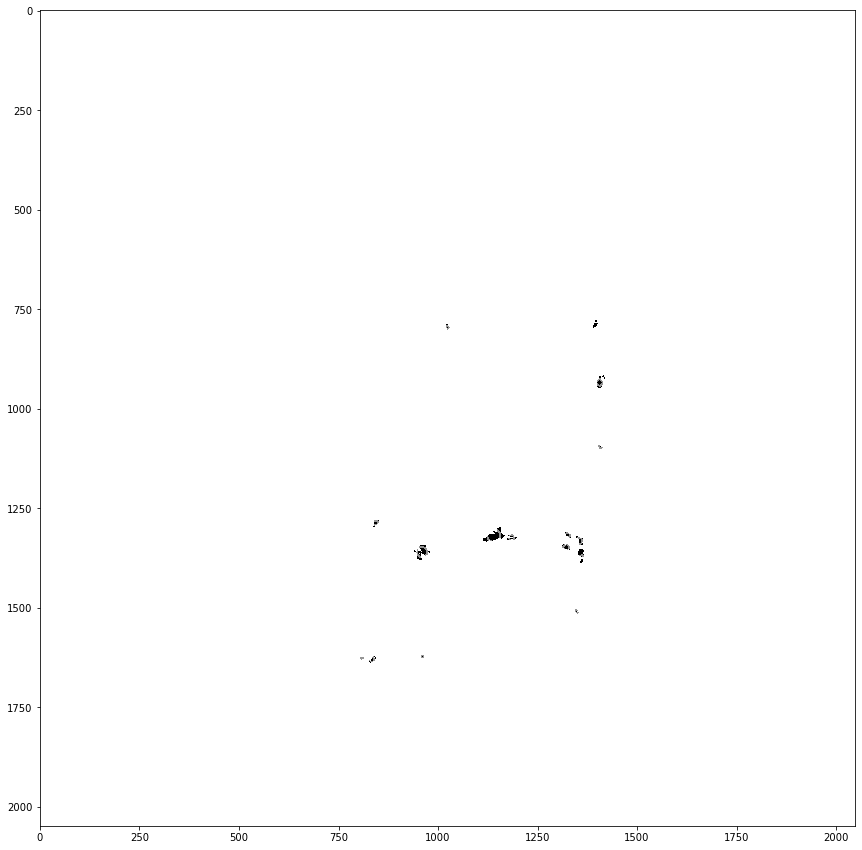

In [35]:
centroid_filteredList = get_merging_circle(morph_pgm_binary_all, filter_labels_list)
len(centroid_filteredList)

### show img

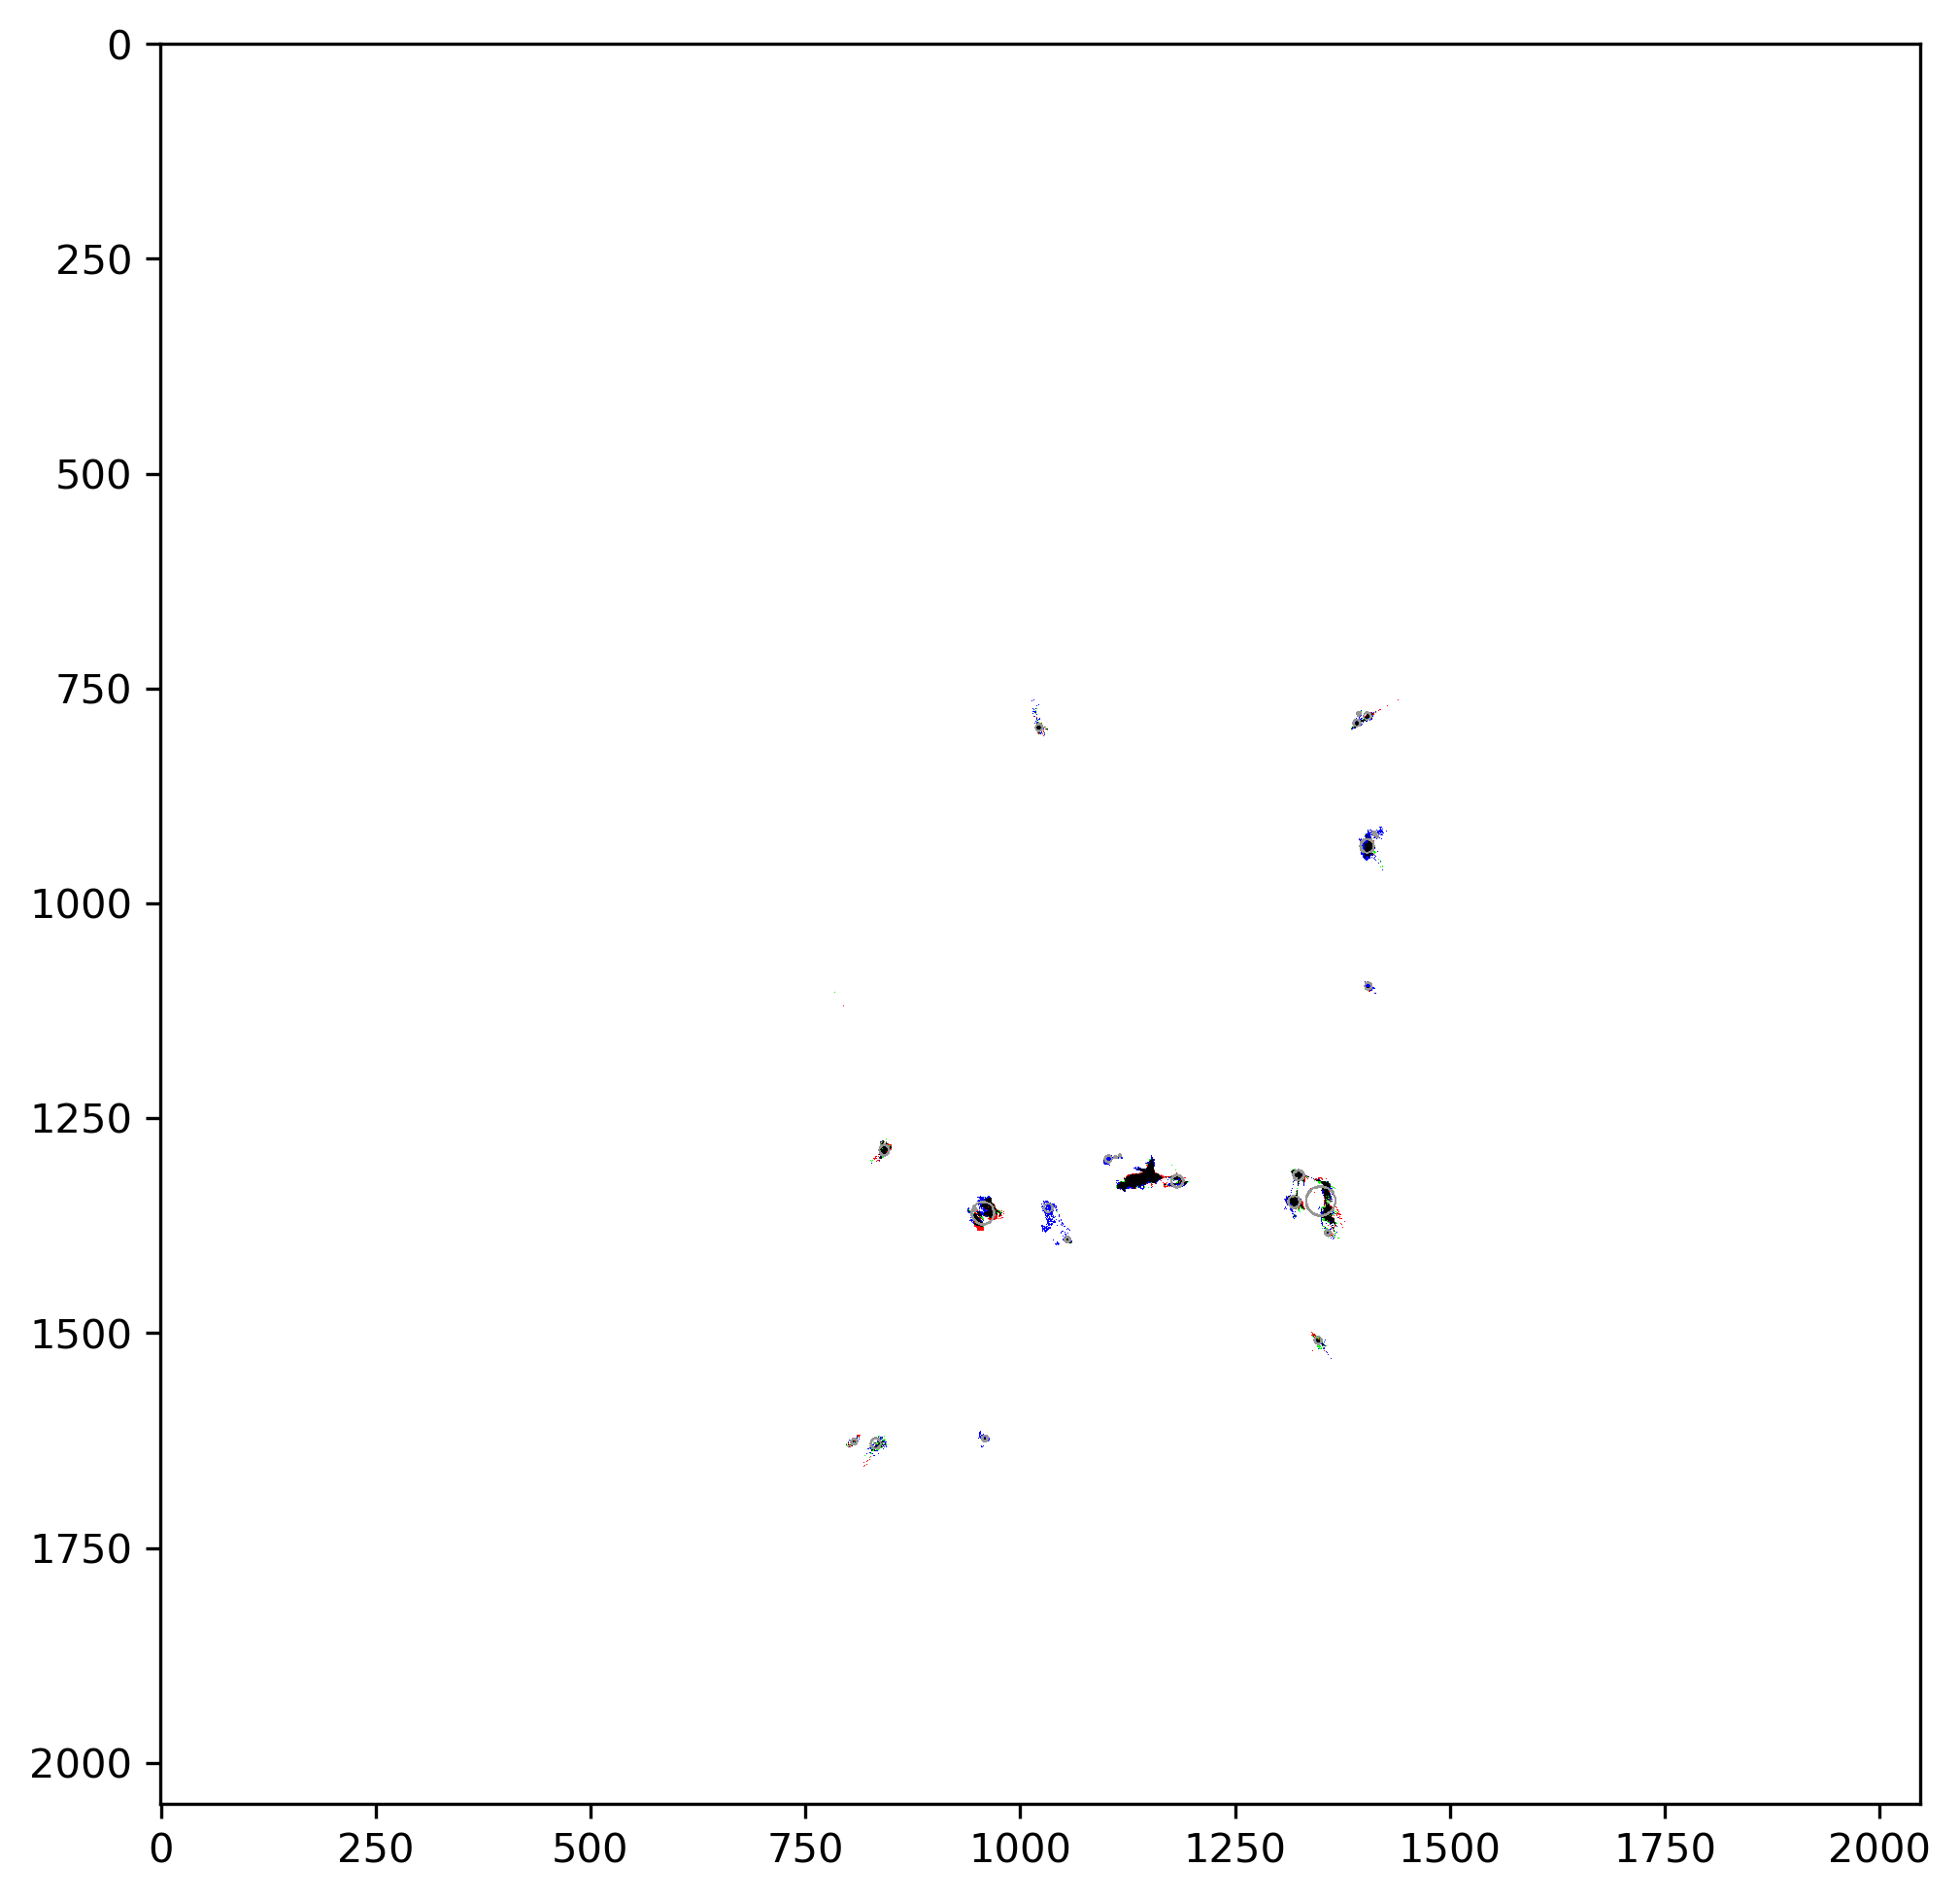

In [24]:
fig1,ax1 = plt.subplots(figsize=(8,8),dpi=300)
plt.imshow(cv2.cvtColor(tmp_color, cv2.COLOR_BGR2RGB))
plt.show()

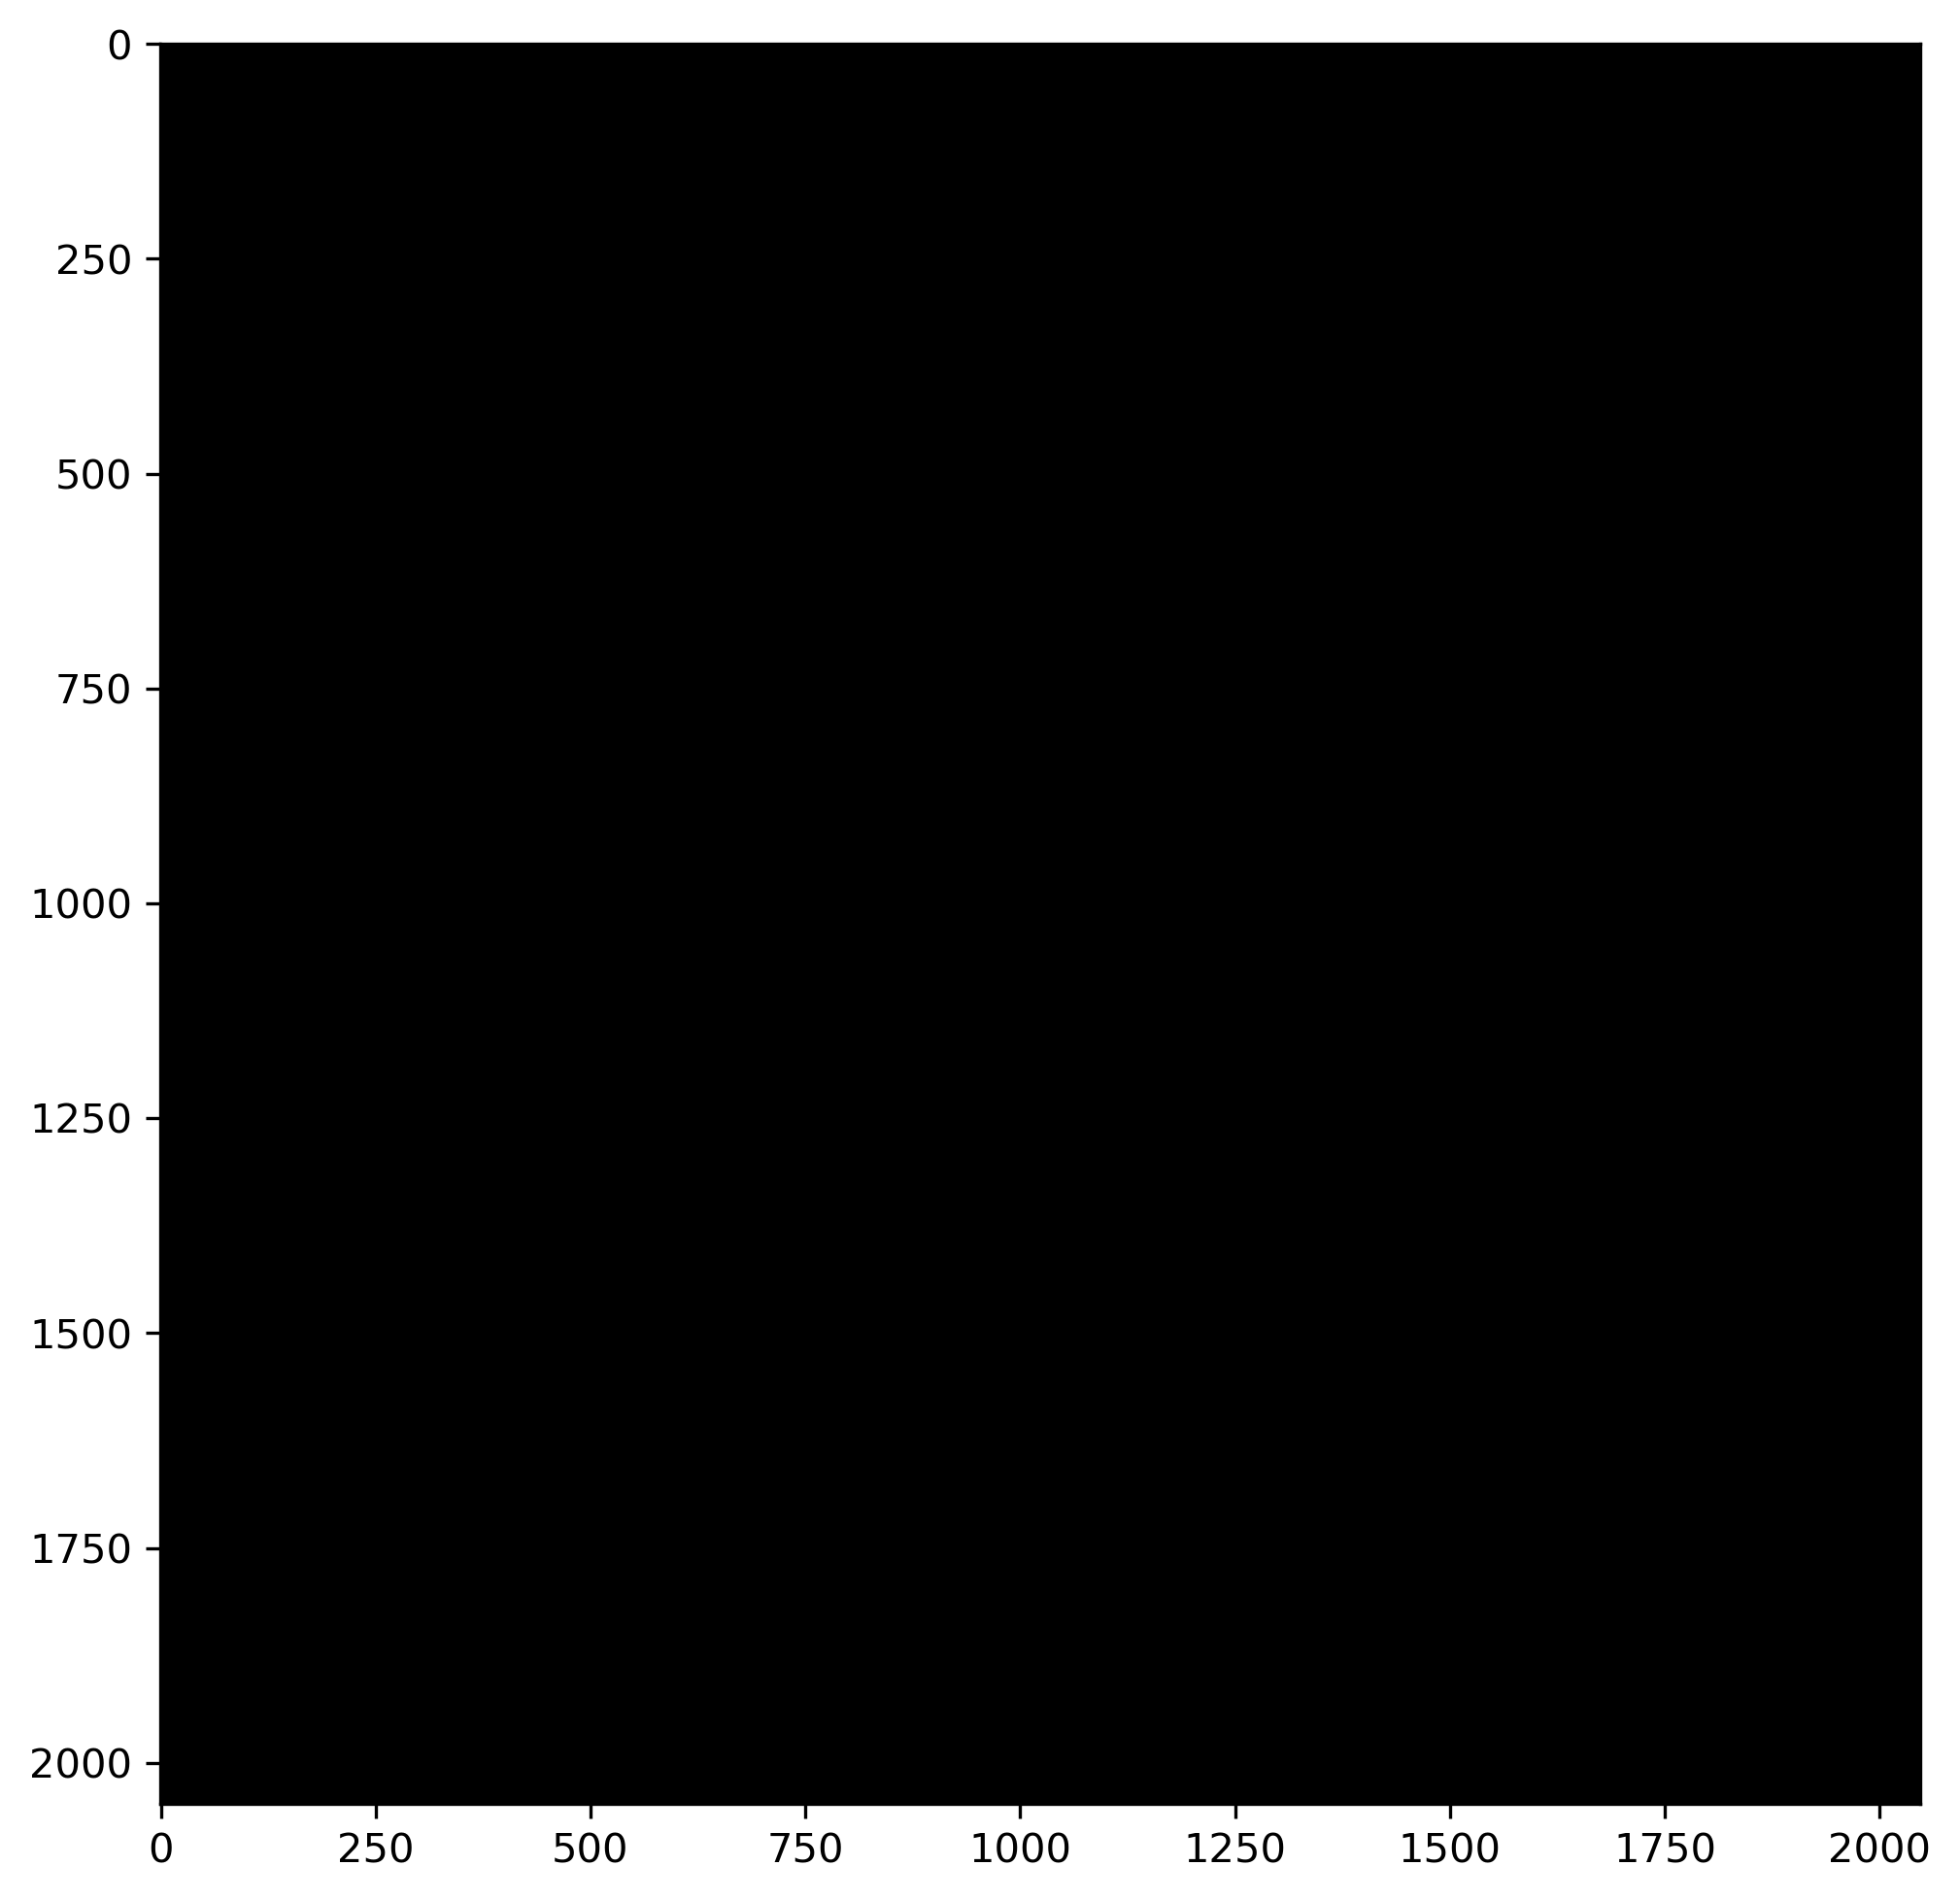

In [38]:
circle_bd = np.zeros(morph_pgm_binary_all.shape, dtype=np.uint8)
for i in centroid_rawList:
    centre_x = i[0]
    centre_y = i[1]
    radius_r = i[2]
    cv2.circle(circle_bd,(int(centre_y), int(centre_x)), int(radius_r+0.5), 150, 2)
fig1,ax1 = plt.subplots(figsize=(8,8),dpi=300)
plt.imshow(cv2.cvtColor(circle_bd, cv2.COLOR_BGR2RGB))
plt.show()

## to utm

TypeError: list indices must be integers or slices, not tuple

## visualize with 

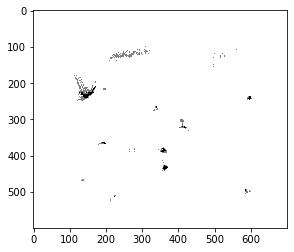

In [7]:
npColorMask = cv2.addWeighted(raw_pgm_binary_tmp1, 0.5, raw_pgm_binary_tmp, 0.5, 0.0)
plt.imshow(cv2.cvtColor(npColorMask[400:1000,1000:1700], cv2.COLOR_BGR2RGB))